In [9]:
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [10]:
import torch
print(torch.cuda.is_available())

True


In [11]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())

1
0


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
# set the random seeds
import numpy as np
np.random.seed(135)
import torch
torch.cuda.manual_seed_all(135)
torch.manual_seed(135)

In [14]:
from data import toyDataset
from model_try import fcNet, mtlNet
from gradnorm_try import gradNorm

In [15]:
# init
n = 1000 #datapoints
p = 250  #input
d = 100 #output
sigmas = [48, 30, 100]
lamda_vals = [0,0,10]
lamda = 0
#sigmas = [1, 100]

In [16]:
# data
dataset = toyDataset(num_data=n, dim_features=p, dim_labels=d, scalars=sigmas)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [17]:
dataset.x.shape

(1000, 250)

In [18]:
dataset.ys.shape

(1000, 3, 100)

In [19]:
# model
net = fcNet(p, d, n_tasks=len(sigmas))
print(net)
mtlnet = mtlNet(net)

fcNet(
  (fc1): Linear(in_features=250, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (heads): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
)


In [20]:
log_weights, log_loss = gradNorm(net=mtlnet, layer=net.fc4, alpha=0.12, dataloader=dataloader,
                                 num_epochs=250, lr1=1e-5, lr2=5e-4, log=True, lamda_vals=lamda_vals, lamda=lamda)

c:\Drive_D\ArhatPersonal\mlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
for x, y in dataloader:
    loss, _, _ = mtlnet(x, y)
    for i in range(len(loss)):
        print("σ = {:3}, Normalized MSE = {:.4f}".format(sigmas[i], loss[i] / sigmas[i] ** 2))
    break

σ =  48, Normalized MSE = 0.4664
σ =  30, Normalized MSE = 0.4341
σ = 100, Normalized MSE = 0.6028


In [22]:
for i in range(len(sigmas)):
    print(f"Final weight of Task {i+1}: {log_weights[-1, i]}")

Final weight of Task 1: 1.1011797189712524
Final weight of Task 2: 1.8046506643295288
Final weight of Task 3: 0.09416967630386353


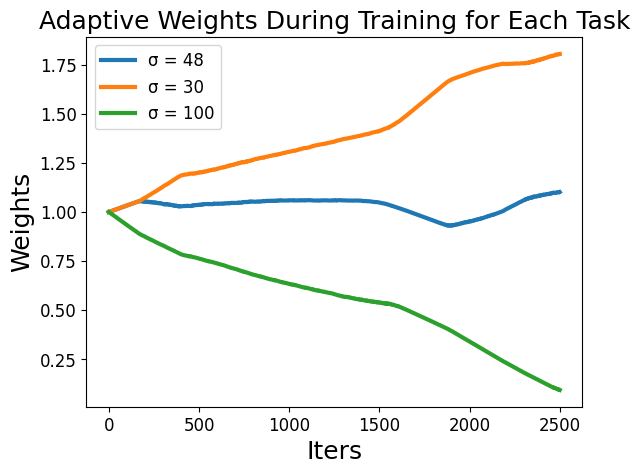

In [23]:
# draw plot

for i in range(len(sigmas)):
    plt.plot(log_weights[:,i], lw=3, label="σ = {}".format(sigmas[i]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Iters", fontsize=18)
plt.ylabel("Weights", fontsize=18)
plt.title("Adaptive Weights During Training for Each Task", fontsize=18)
plt.legend(fontsize=12)
plt.show()

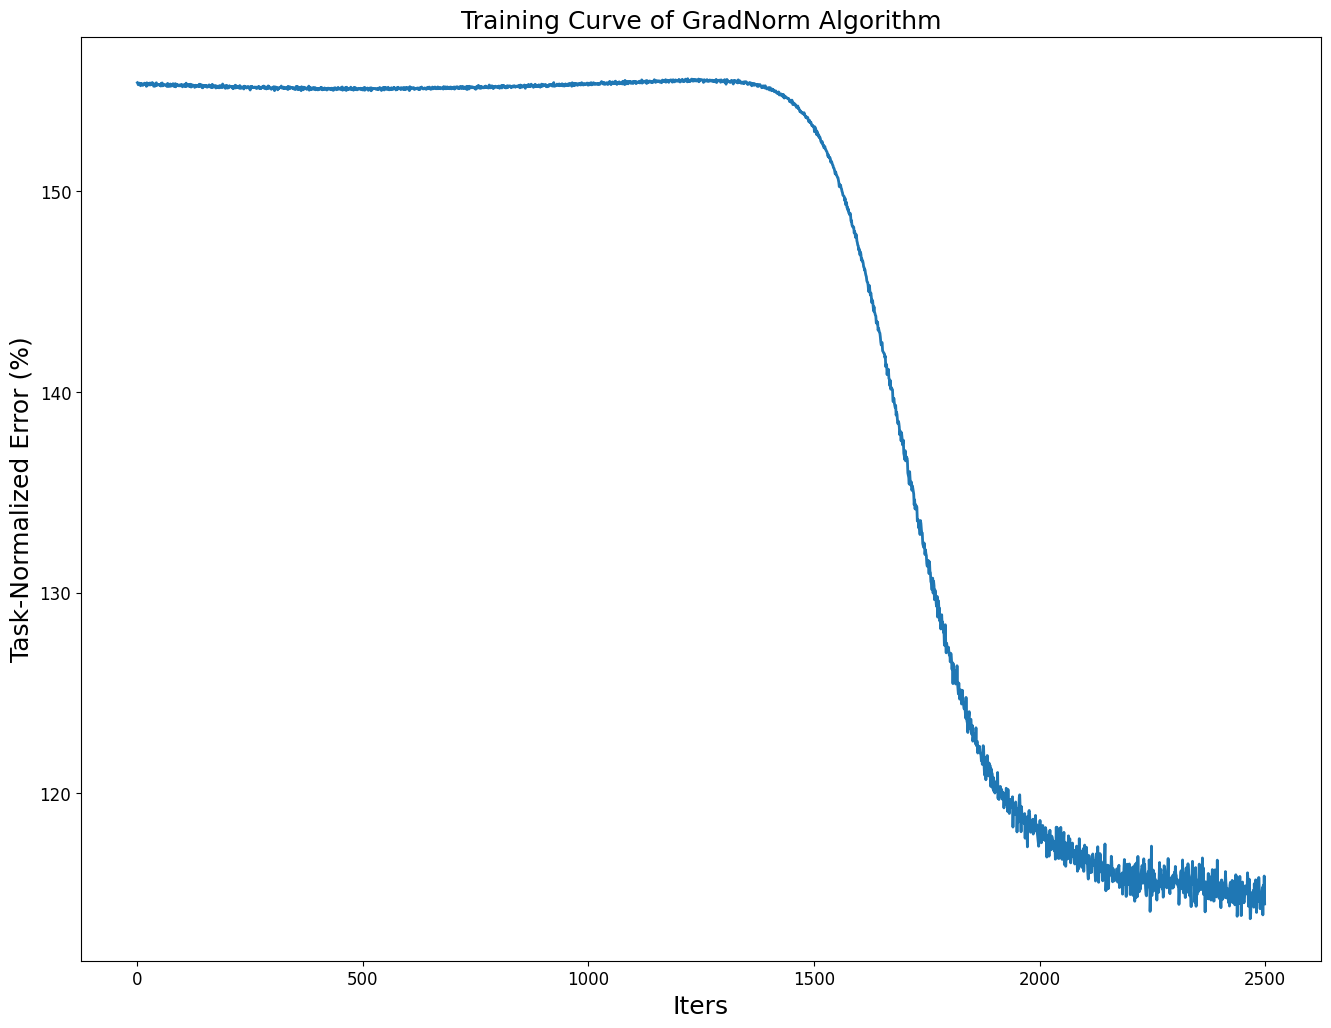

In [24]:
# draw plot
plt.figure(figsize=(16, 12))
plt.plot(log_loss.mean(axis=1)*100, lw=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=18)
plt.ylabel("Task-Normalized Error (%)", fontsize=18)
plt.title("Training Curve of GradNorm Algorithm", fontsize=18)
plt.show()

In [25]:
log_loss.mean(axis=1)[-1]

1.1449239